# Predict bed count distributions for subgroups

It is often the case that pressures build up on certain areas of the hospital, or for subgroups of patients. For example, due to infections in the community, there might be particulary demand for respiratory specialties, or for male geriatric beds. 

In this notebook I show how `patientflow` functions can be used to create predictions for some subgroup which might be 
* specific areas of the hospital (eg medical or paediatric beds)
* sub-groups defined by a demographic characteristic (eg sex) 

I will first demonsrate the use of a `SequencePredictor` class, that can be used to predict each patient's probability of admission to a clinical area if they are admitted. Here I show predictions to four specialties: medical, surgical, haematology/oncology or paediatric. I'll load real patient data and show how the `SequencePredictor` is trained using sequences of consult requests made while patients were in the ED.

If we assume that two events - a patient being admitted, and a patient requiring a particular specialty if admitted - are independent, the probabilities of those events can be multiplied to give a probabilty of admission to a specialty. I'll show the use of this approach to generate bed count distributions for each specialty.

I'll also demonstrate the disaggregation of predicted bed counts by sex.


## Loading real patient data

Following the approaach taken in the previous notebook, I'll first load some real patient data. 

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [3]:
import pandas as pd
from patientflow.load import set_file_paths, load_data, load_config_file

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load the config file to set the dates for the training, validation and test sets
params = load_config_file(config_path)
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# apply the temporal splits
from datetime import date   
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)


Inferred project root: /Users/zellaking/Repos/patientflow
Split sizes: [53801, 6519, 19494]


## Train a model to predict probability of admission to each specialty

In this example, the data used as input comprise sequences of consults issued while the patient was in the ED. Below, the `consultation_sequence` column shows the ordered sequence of consultation requests up to the moment of the snapshot, and the `final_sequence` shows the ordered sequence at the end of the ED visit. The `specialty` column records which specialty the patient was admitted to.  

In [4]:
ed_visits[(ed_visits.is_admitted) & (ed_visits.prediction_time == (9,30))][['consultation_sequence', 'final_sequence', 'specialty']].head(10)

,consultation_sequence,final_sequence,specialty
snapshot_id,,,
59,['surgical'],['surgical'],surgical
117,[],['surgical'],surgical
124,[],['surgical'],surgical
127,[],['surgical'],surgical
141,[],['surgical'],surgical
218,['ambulatory'],['ambulatory'],NaN
452,"['obs_gyn', 'obs_gyn']","['obs_gyn', 'obs_gyn']",surgical
474,[],['paeds'],paediatric
485,[],['acute'],medical


Below I demonstrate training the model. A rooted decision-tree is used to calculate the probability of an ordered sequence of consultations (observed at the snapshot, which could be none) resulting in each final sequences at the end of the ED visit, and the probabiltity of each of those final sequences being associated with admission to each specialty. 

This sequence predictor could be applied to other types of data, such as sequences of ED locations, or sequences of clinical teams. Therefore, the `SequencePredictor` arguments have been given generic names: 

* `input_var` - the interim node in the decision tree, observed at the snapshot
* `grouping_var` - the terminal node in the decision tree, observed in this example at the end of the ED visit
* `outcome_var` - the final outcome to be predicted

The `apply_special_category_filtering` argument provides for the handling of certain categories in a specific way. For example, under 18 patients might always be assumed to be visiting paediatric specialties. 


In [5]:
from patientflow.predictors.sequence_predictor import SequencePredictor

spec_model = SequencePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=False,
)

spec_model.fit(train_visits)

SequencePredictor(
    input_var='consultation_sequence',
    grouping_var='final_sequence',
    outcome_var='specialty',
    apply_special_category_filtering=False,
    admit_col='is_admitted'
)

From the weights that are returned, we can view the probability of being admitted to each specialty for a patient who has no consultation sequence at the time of prediction

In [6]:
print(
    f'Probability of being admitted to each specialty at the end of the visit if no consultation result has been made by the time of the snapshot:\n'
    f'{dict((k, round(v, 3)) for k, v in spec_model.weights[()].items())}'
)



Probability of being admitted to each specialty at the end of the visit if no consultation result has been made by the time of the snapshot:
{'surgical': 0.257, 'medical': 0.604, 'paediatric': 0.063, 'haem/onc': 0.077}


Similar we can view the probability of being admitted to each specialty after a consultation request to acute medicine

In [7]:
print(
    f'\nProbability of being admitted to each specialty if one consultation request to acute medicine has taken place by the time of the snapshot:\n'
    f'{dict((k, round(v, 3)) for k, v in spec_model.weights[("acute",)].items())}'
)


Probability of being admitted to each specialty if one consultation request to acute medicine has taken place by the time of the snapshot:
{'surgical': 0.015, 'medical': 0.951, 'paediatric': 0.001, 'haem/onc': 0.033}


The intermediate mapping of consultation_sequence to final_sequence can be accessed from the trained model like this. The first row shows the probability of a null sequence (ie no consults yet) ending in any of the final_sequence options. 

In [8]:
spec_model.input_to_grouping_probs.iloc[:, :10]

final_sequence,(),"(acute,)","(acute, acute)","(acute, acute, medical)","(acute, acute, medical, surgical)","(acute, acute, mental_health)","(acute, acute, palliative)","(acute, acute, surgical)","(acute, allied)","(acute, allied, acute)"
consultation_sequence,,,,,,,,,,
(),0.013913,0.428535,0.013408,0.000506,0.000253,0.000506,0.00000,0.000506,0.005312,0.000253
"(acute,)",0.000000,0.819803,0.006150,0.000000,0.000000,0.000000,0.00000,0.000000,0.012300,0.000000
"(acute, acute)",0.000000,0.000000,0.875000,0.093750,0.000000,0.000000,0.03125,0.000000,0.000000,0.000000
"(acute, acute, medical)",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
"(acute, allied)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
"(surgical, paeds)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
"(surgical, surgical)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
"(surgical, surgical, acute)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


## Using the `SequencePredictor` 

Below I apply the predict function to get each patient's probability of being admitted to the four specialties.

In [9]:
test_visits['consultation_sequence'].head().apply(spec_model.predict)

snapshot_id
2        {'surgical': 0.25677749360613816, 'medical': 0...
55916    {'surgical': 0.018907563025210086, 'medical': ...
55917    {'surgical': 0.018907563025210086, 'medical': ...
55918    {'surgical': 0.018907563025210086, 'medical': ...
58564    {'surgical': 0.8329853862212944, 'medical': 0....
Name: consultation_sequence, dtype: object

A dictionary is returned for each patient, with probabilites summed to 1. To get each patient's probability of admission to one specialty indexed in the dictionary, we can select that key as shown below:

In [10]:
print("Probability of admission to medical specialty for five patients:")
test_visits['consultation_sequence'].head().apply(spec_model.predict).apply(lambda x: x['medical']).values


Probability of admission to medical specialty for five patients:


array([0.60396419, 0.05462185, 0.05462185, 0.05462185, 0.1263048 ])

## Generate predicted bed count distributions by specialty.

I now have a model I can use to get a patient's probability of admission to each of the four specialties: medical, surgical, haematology/oncology or paediatric, if admitted. I'll use this these probabilities, with each patient's probability of admission after ED, to generate predicted bed count distributions for each specialty.

For that I'll also need an admission prediction model, which is set up below. 

In [11]:
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-102",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]


admission_model = train_classifier(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid={"n_estimators": [20, 30, 40]},
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_time=(9,30),
    visit_col="visit_number",
    calibrate_probabilities=True,
    calibration_method="isotonic",
    use_balanced_training=True,
)


### Prepare group snapshots

The logic below is similar to previous notebooks, but this time I'll add the specialty probabilities as weights in the `get_prob_dist` function

In [12]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict

prob_dist_dict = {}
first_group_snapshot_key = test_visits.snapshot_date.min()

prediction_snapshots = test_visits[(test_visits.snapshot_date == first_group_snapshot_key) & (test_visits.prediction_time == (9,30))]

# format patient snapshots for input into the admissions model
X_test, y_test = prepare_patient_snapshots(
    df=prediction_snapshots, 
    prediction_time=(9,30), 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col='visit_number'
)

# prepare group snapshots dict to indicate which patients comprise the group we want to predict for
group_snapshots_dict = prepare_group_snapshot_dict(
    prediction_snapshots
    )

group_snapshots_dict


{datetime.date(2031, 10, 1): [60311,
  60315,
  60322,
  60328,
  60331,
  60333,
  60336,
  60338,
  60339,
  60340,
  60341,
  60342,
  60343,
  60344,
  60348,
  60349,
  60352,
  60353,
  60354,
  60356,
  60359,
  60360,
  60361]}

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


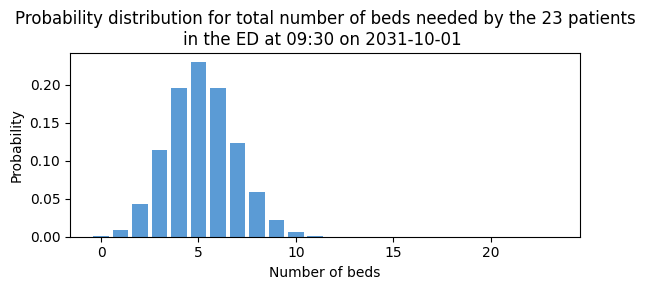

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


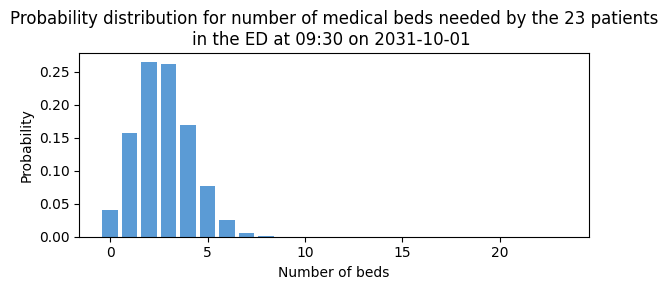

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


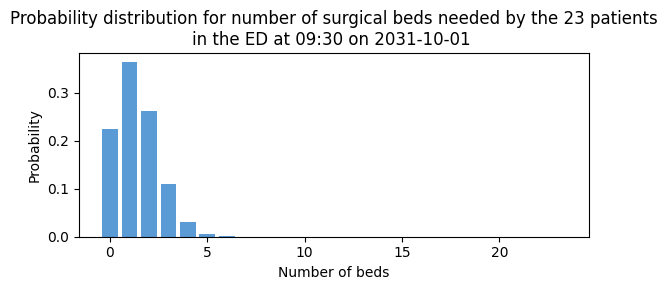

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


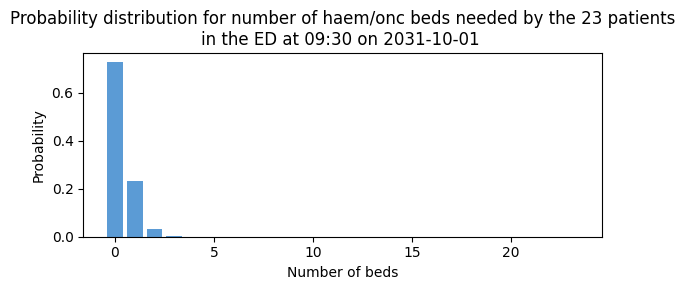

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


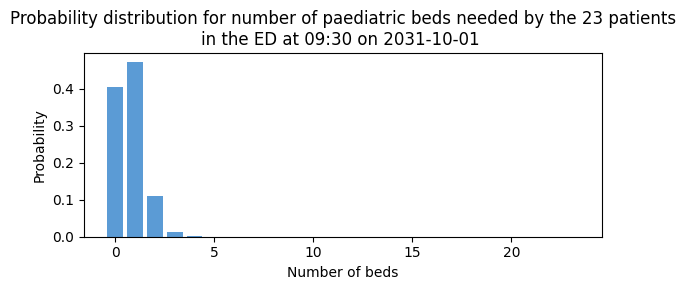

In [133]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.aggregate import get_prob_dist
from patientflow.viz.utils import format_prediction_time

# get probability distribution for this time of day
prob_dist_dict = get_prob_dist(
        group_snapshots_dict, X_test, y_test, admission_model
    )

title = (
    f'Probability distribution for total number of beds needed by the '
    f'{len(prediction_snapshots)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key} '
)
prob_dist_plot(prob_dist_dict[first_group_snapshot_key]['agg_predicted'], title, 
    include_titles=True)

for specialty in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    prob_admission_to_specialty = prediction_snapshots['consultation_sequence'].apply(spec_model.predict).apply(lambda x: x[specialty])
# get probability distribution for this time of day
    prob_dist_dict = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admission_model, weights=prob_admission_to_specialty
        )

    title = (
        f'Probability distribution for number of {specialty} beds needed by the '
        f'{len(prediction_snapshots)} patients\n'
        f'in the ED at {format_prediction_time((9,30))} '
        f'on {first_group_snapshot_key} '
    )
    prob_dist_plot(prob_dist_dict[first_group_snapshot_key]['agg_predicted'], title, 
        include_titles=True)


## Generating predicted bed counts by demographic variables

Disaggregation of predictions using unchanging attributes like sex is very straightforward.

for 

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


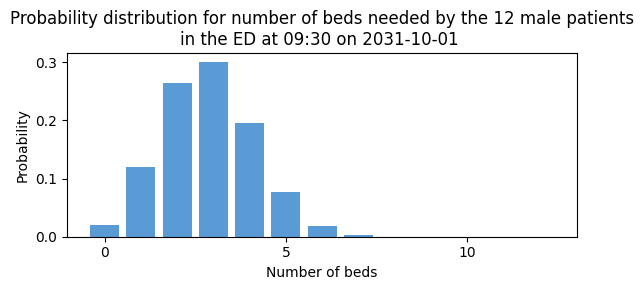

Calculating probability distributions for 1 snapshot dates
Processed 1 snapshot dates


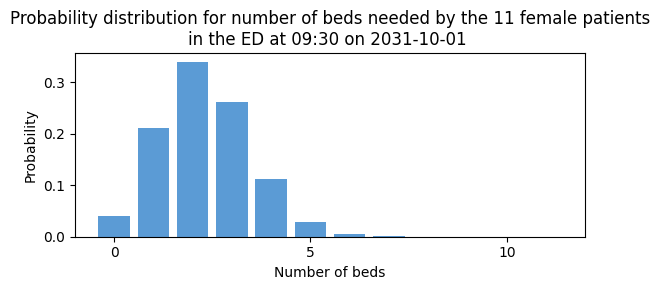

In [136]:
for sex in ['M', 'F']:

    prediction_snapshots = test_visits[(test_visits.snapshot_date == first_group_snapshot_key) & 
                                       (test_visits.sex == sex) &
                                       (test_visits.prediction_time == (9,30))]
    
    group_snapshots_dict = prepare_group_snapshot_dict(
        prediction_snapshots
    )

    prob_dist_dict = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admission_model
        )

    title = (
        f'Probability distribution for number of beds needed by the '
        f'{len(prediction_snapshots)} {"male" if sex == "M" else "female"} patients\n'
        f'in the ED at {format_prediction_time((9,30))} '
        f'on {first_group_snapshot_key} '
    )
    prob_dist_plot(prob_dist_dict[first_group_snapshot_key]['agg_predicted'], title, 
        include_titles=True)

## Conclusion

In this notebook I have presented examples of how to disaggregate predicted bed counts according to sub-categories of interest. 

Some subgroups are straightfoward to generate at inference time, if they are based on static attributes of the patient such as sex or perhaps ethnicity. 

Demand on clinical areas can be predicted dynamically, using some kind of real-time signal collected about a patient that is related to their likely clinical area. 

In the following notebook, I demonstrate a fully worked up example of how the functions provided in `patientflow` are in use at University College London Hospital to predict emergency demand. 